## Data Preprocessing,Feature Engineering And Feature Selection

In [ ]:
#Importing Liraries

# Importing Libraries
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
import shutil
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib
matplotlib.use(u'nbAgg')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle
import random
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from scipy.sparse import hstack
from wordcloud import WordCloud


# Utilities
#from viz_utils import *
#from custom_transformers import *
#from ml_utils import *

# DataPrep
import re
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import Normalizer

# Modeling

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier, AdaBoostClassifier
#Metrics
from sklearn.metrics import log_loss,accuracy_score, confusion_matrix, f1_score





#Importing the Libraries
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import load_model




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
cd /content/drive/MyDrive/case study

/content/drive/MyDrive/case study


In [ ]:
#reading data
data = pd.read_pickle('final.pkl')
data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,review_score,review_comment_message,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_month_yr,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day,day_to_delivery,words_per_review
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,1,credit_card,1,18.12,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,1,"Não testei o produto ainda, mas ele veio corre...",2017,10,Oct,201710,20171002,Oct-17,2,0,Mon,10,Morning,8,32
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-18 14:44:43,2017-08-28,1,credit_card,3,37.77,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,1,Deveriam embalar melhor o produto. A caixa vei...,2017,8,Aug,201708,20170815,Aug-17,15,1,Tue,18,Afternoon,2,16
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-07 18:30:01,2017-08-15,1,credit_card,1,37.77,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,1,"Só achei ela pequena pra seis xícaras ,mais é ...",2017,8,Aug,201708,20170802,Aug-17,2,2,Wed,18,Afternoon,5,12
5,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2017-10-23 23:26:46,2017-10-25 02:14:11,2017-11-07 18:04:59,2017-11-13,1,boleto,1,44.09,e781fdcc107d13d865fc7698711cc572,88032,florianopolis,SC,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-31 02:14:11,29.99,14.10,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,1,nao_reveja,2017,10,Oct,201710,20171023,Oct-17,23,0,Mon,23,Night,14,1
6,6ea2f835b4556291ffdc53fa0b3b95e8,c7340080e394356141681bd4c9b8fe31,delivered,2017-11-24 21:27:48,2017-11-25 00:21:09,2017-12-28 18:59:23,2017-12-21,1,credit_card,10,356.12,3e4fd73f1e86b135b9b121d6abbe9597,19400,presidente venceslau,SP,1,be021417a6acb56b9b50d3fd2714baa8,f5f46307a4d15880ca14fab4ad9dfc9b,2017-11-30 00:21:09,339.00,17.12,utilidades_domesticas,48.0,664.0,6.0,14300.0,38.0,34.0,34.0,housewares,0,"Inicialmente, na data da compra o produto era ...",2017,11,Nov,201711,20171124,Nov-17,24,4,Fri,21,Night,33,22


#1.Data Preprocessing

## Preprocessing Review Text

In [ ]:
#text data preprocessing
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import nltk
nltk.download('rslp')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


True

In [ ]:
# portugese language stopwords
stopwords_pt = stopwords.words("portuguese")
print(f'Total portuguese stopwords in the nltk.corpous module: {len(stopwords_pt)}')
print('Few Stopwords:',stopwords_pt[0:20])

Total portuguese stopwords in the nltk.corpous module: 204
Few Stopwords: ['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da', 'em', 'um', 'para', 'com', 'não', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais']


In [ ]:
#removing 'nao' & 'nem'
stopwords_pt.remove('não')
stopwords_pt.remove('nem')

In [ ]:
data['review_comment_message'].head(5)

0    Não testei o produto ainda, mas ele veio corre...
3    Deveriam embalar melhor o produto. A caixa vei...
4    Só achei ela pequena pra seis xícaras ,mais é ...
5                                           nao_reveja
6    Inicialmente, na data da compra o produto era ...
Name: review_comment_message, dtype: object

In [ ]:
#https://www.kaggle.com/camillafonseca/nlp-an-lise-de-sentimento-do-olist-para-iniciantes
#https://www.kaggle.com/thiagopanini/e-commerce-sentiment-analysis-eda-viz-nlp
def preprocess_text(texts):
    hyperlinks = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+' # check for hyperlinks
    dates = '([0-2][0-9]|(3)[0-1])(\/|\.)(((0)[0-9])|((1)[0-2]))(\/|\.)\d{2,4}' # check for dates
    currency_symbols = '[R]{0,1}\$[ ]{0,}\d+(,|\.)\d+' # check for currency symbols
    preprocessed_text = []
    stemmer = RSLPStemmer() # portugese nltk stemmer
    for sent in tqdm(texts):
        sent = re.sub(r"[\n\t\-\\\/]"," ",sent)#removing the new line,tab  
        sent = re.sub(hyperlinks, ' url ', sent) # replacing hyperlinks with 'url'
        sent = re.sub(dates, ' ', sent) # removing dates
        sent = re.sub(currency_symbols, ' dinheiro ', sent) # replacing currency symbols with 'dinheiro'
        sent = re.sub('[0-9]+', ' numero ', sent) # removing digits
        sent = re.sub('([nN][ãÃaA][oO]|[ñÑ]| [nN] )', ' negação ', sent) # replacing no with negative
        sent = re.sub('\W', ' ', sent) # removing extra whitespaces
        sent = re.sub('\s+', ' ', sent) # removing extra spaces
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords_pt) # removing stopwords
        sent = ' '.join(stemmer.stem(e.lower()) for e in sent.split()) # stemming the words
        preprocessed_text.append(sent.lower().strip())
        
    return preprocessed_text

In [ ]:
processed_text = preprocess_text(data['review_comment_message'].values)

100%|██████████| 97255/97255 [00:23<00:00, 4084.24it/s]


In [ ]:
data['review_comment_message'] = processed_text
data['review_comment_message'].head(5)

0    neg test produt aind vei corret boa cond apen ...
3    dev embal melhor produt caix vei tod amass vou...
4                   ach pequen pra seil xíc bom produt
5                                           neg _revej
6    inic dat compr produt ser entreg numer numer h...
Name: review_comment_message, dtype: object

In [ ]:
col= ['order_id',
 'customer_id',
 'order_purchase_timestamp',
 'order_approved_at',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
  'customer_unique_id',
 'order_item_id',
 'product_id',
 'seller_id',
 'shipping_limit_date',
 'order_purchase_month_name',
 'order_purchase_year_month',
 'order_purchase_date',
 'order_purchase_month_yr',
 'order_purchase_day',
 'order_purchase_dayofweek',
 'order_purchase_dayofweek_name',
 'order_purchase_hour',
 'order_purchase_time_day','customer_city','customer_zip_code_prefix','product_category_name']

In [ ]:
data.drop(columns=col,axis=1,inplace=True)

In [ ]:
data.head()

,order_status,payment_sequential,payment_type,payment_installments,payment_value,customer_state,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,review_score,review_comment_message,order_purchase_year,order_purchase_month,day_to_delivery,words_per_review
0,delivered,1,credit_card,1,18.12,SP,29.99,8.72,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,1,neg test produt aind vei corret boa cond apen ...,2017,10,8,32
3,delivered,1,credit_card,3,37.77,SP,29.99,7.78,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,1,dev embal melhor produt caix vei tod amass vou...,2017,8,2,16
4,delivered,1,credit_card,1,37.77,SP,29.99,7.78,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,1,ach pequen pra seil xíc bom produt,2017,8,5,12
5,delivered,1,boleto,1,44.09,SC,29.99,14.10,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,1,neg _revej,2017,10,14,1
6,delivered,1,credit_card,10,356.12,SP,339.00,17.12,48.0,664.0,6.0,14300.0,38.0,34.0,34.0,housewares,0,inic dat compr produt ser entreg numer numer h...,2017,11,33,22


<h3>Splitting data into Train and Test: Stratified Sampling</h3>


In [ ]:
y = data['review_score'].values
X = data.drop(['review_score'], axis=1)
print("      X ","        y")
print(X.shape,y.shape)
print('\n')
X.head(1)   

      X          y
(97255, 21) (97255,)




,order_status,payment_sequential,payment_type,payment_installments,payment_value,customer_state,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,review_comment_message,order_purchase_year,order_purchase_month,day_to_delivery,words_per_review
0,delivered,1,credit_card,1,18.12,SP,29.99,8.72,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,neg test produt aind vei corret boa cond apen ...,2017,10,8,32


In [ ]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=25)


print(" X_train","   y_train")
print(X_train.shape,y_train.shape)
print('-'*15)
print("X_test","    y_test")
print(X_test.shape,y_test.shape)

 X_train    y_train
(77804, 21) (77804,)
---------------
X_test     y_test
(19451, 21) (19451,)


#2.Featurization

## Encoding Categorical Features





### Encoding Categorical Features: order_status

In [ ]:
vect_os_tr = CountVectorizer(binary= True)
vect_os_tr.fit(X_train['order_status'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
order_st_tr = vect_os_tr.transform(X_train['order_status'].values)

order_st_te = vect_os_tr.transform(X_test['order_status'].values)
name_os =vect_os_tr.get_feature_names()

print("After vectorizations")
print(order_st_tr.shape, y_train.shape)
print(order_st_tr.shape, y_test.shape)
print(name_os)

After vectorizations
(77804, 7) (77804,)
(77804, 7) (19451,)
['approved', 'canceled', 'delivered', 'invoiced', 'processing', 'shipped', 'unavailable']


### Encoding Categorical Features:payment_type

In [ ]:
vectorizer = CountVectorizer(binary= True)
vectorizer.fit(X_train['payment_type'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
pay_typ_tr = vectorizer.transform(X_train['payment_type'].values)

pay_typ_te = vectorizer.transform(X_test['payment_type'].values)
name_typ = vectorizer.get_feature_names()
print("After vectorizations")
print(pay_typ_tr.shape, y_train.shape)
print(pay_typ_tr.shape, y_test.shape)


After vectorizations
(77804, 4) (77804,)
(77804, 4) (19451,)


### Encoding Categorical Features:product_category_name_english

In [ ]:
vectorizer = CountVectorizer(binary= True)
vectorizer.fit(X_train['product_category_name_english'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
prod_cat_tr = vectorizer.transform(X_train['product_category_name_english'].values)

prod_cat_te = vectorizer.transform(X_test['product_category_name_english'].values)
name_prd = vectorizer.get_feature_names()
print("After vectorizations")
print(prod_cat_tr.shape, y_train.shape)
print(prod_cat_tr.shape, y_test.shape)

After vectorizations
(77804, 71) (77804,)
(77804, 71) (19451,)


### Encoding Categorical Features: customer_state

In [ ]:
vectorizer = CountVectorizer(binary= True)
vectorizer.fit(X_train['customer_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
state_tr = vectorizer.transform(X_train['customer_state'].values)

state_te = vectorizer.transform(X_test['customer_state'].values)
name_st = vectorizer.get_feature_names()

print("After vectorizations")
print(state_tr.shape, y_train.shape)
print(state_tr.shape, y_test.shape)

After vectorizations
(77804, 27) (77804,)
(77804, 27) (19451,)


## Featurization of text data

In [ ]:
import fasttext.util
fasttext.util.download_model('pt', if_exists='ignore')  #Portuguese

In [ ]:
from gensim.models import FastText
ft_model = FastText.load_fasttext_format('/content/drive/MyDrive/case study/cc.pt.300.bin')

In [ ]:
ft_model.wv['melhor'].shape

(300,)

In [ ]:
ft_model.similar_by_vector('produt')

[('produts', 0.6906509399414062),
 ('produ', 0.6056191921234131),
 ('produtoa', 0.5977535843849182),
 ('produe', 0.57929527759552),
 ('produto', 0.5772074460983276),
 ('produtos', 0.5754655003547668),
 ('produtoo', 0.5647249221801758),
 ('protudo', 0.5558850765228271),
 ('produtoe', 0.5553520321846008),
 ('vend', 0.5546207427978516)]

In [ ]:
def tfidfWord2Vector(text,ft_words,tfidf_words,tf_values):
    # average Word2Vec
    # compute average word2vec for each review.
    tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(text): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in ft_words) and (word in tfidf_words):
                vec = ft_model.wv[word] # embeddings[word] 
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = tf_values[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)
    tfidf_w2v_vectors = np.asarray(tfidf_w2v_vectors)
    
    return tfidf_w2v_vectors

In [ ]:
# encoding review comment message using Tfidf weighted W2V
tfidf = TfidfVectorizer()
tfidf.fit(X_train['review_comment_message'])


# we are converting a dictionary with word as a key, and the idf as a value
tf_values = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))
tfidf_words = set(tfidf.get_feature_names())
ft_words = list(ft_model.wv.vocab.keys()) # list(embeddings.keys())

tfidf_w2v_vectors_train = tfidfWord2Vector(X_train['review_comment_message'].values,ft_words,tfidf_words,tf_values)
tfidf_w2v_vectors_test = tfidfWord2Vector(X_test['review_comment_message'].values,ft_words,tfidf_words,tf_values)

100%|██████████| 19451/19451 [23:41<00:00, 13.68it/s]


In [ ]:
pickle.dump(tfidf_w2v_vectors_train,open('tfidf_w2v_vectors_train_1.pkl','wb'))
pickle.dump(tfidf_w2v_vectors_test,open('tfidf_w2v_vectors_test_1.pkl','wb'))

In [ ]:
tfidf_w2v_vectors_train = pickle.load( open('tfidf_w2v_vectors_train.pkl','rb'))

In [ ]:
tfidf_w2v_vectors_test = pickle.load( open('tfidf_w2v_vectors_test.pkl','rb'))

## Numerical_features

In [ ]:
from sklearn.preprocessing import Normalizer
def normalizer(col):
  normalizer = Normalizer()
  normalizer.fit(X_train[col].values.reshape(1,-1))
  X_train_norm = normalizer.transform(X_train[col].values.reshape(-1,1))
  X_test_norm = normalizer.transform(X_test[col].values.reshape(-1,1))
  return X_train_norm,X_test_norm

In [ ]:
# numerical features
num=['payment_sequential',
 'payment_installments',
 'payment_value',
 'price',
 'freight_value',
 'product_name_lenght',
 'product_description_lenght',
 'product_photos_qty',
 'product_weight_g',
 'product_length_cm',
 'product_height_cm',
 'product_width_cm',
 'day_to_delivery']

In [ ]:
tr=[]
te=[]
for i in num:
  a,b = normalizer(i)
  tr.append(a)
  te.append(b)

In [ ]:
from scipy.sparse import hstack,csr_matrix
import numpy as np

X_tr_num = np.hstack((tr))
X_te_num = np.hstack((te))


print("Final Data matrix")
print(X_tr_num.shape, y_train.shape)
print(X_te_num.shape, y_test.shape)

Final Data matrix
(77804, 13) (77804,)
(19451, 13) (19451,)


In [ ]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((tfidf_w2v_vectors_train,order_st_tr,pay_typ_tr,prod_cat_tr,state_tr,X_tr_num)).tocsr()
X_te = hstack((tfidf_w2v_vectors_test,order_st_te,pay_typ_te,prod_cat_te,state_te,X_te_num)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)

print(X_te.shape, y_test.shape)
print("="*100)
print('')

Final Data matrix
(77804, 422) (77804,)
(19451, 422) (19451,)



#3.Baseline Models

### Random Model

In [ ]:
def confusion_matrices_plot(y_real, y_pred, y_test,y_test_pred,name):
    # representing confusion matric in heatmap format
    # https://seaborn.pydata.org/generated/seaborn.heatmap.html
    cmap_ = sns.light_palette("#425a90",as_cmap=True)
    cmap = sns.light_palette("#000000",as_cmap=True)
    C1 = confusion_matrix(y_real,y_pred)
    C2 = confusion_matrix(y_test,y_test_pred)
    
    fig,ax = plt.subplots(1, 2, figsize=(15,5))
    ax1 = sns.heatmap(C1, annot=True, cmap=cmap, fmt=".2f", ax = ax[0])
    ax1.set_xlabel('Predicted Class')
    ax1.set_ylabel('Original Class')
    ax1.set_title("Train Confusion matrix")

    ax2 = sns.heatmap(C2, annot=True, cmap=cmap_, fmt=".2f", ax = ax[1])
    ax2.set_xlabel('Predicted Class')
    ax2.set_ylabel('Original Class')
    ax2.set_title("Test Confusion matrix")
    plt.savefig(name, dpi=480, bbox_inches='tight')
    plt.show()

Train f1-score 0.4252405451644861
Test f1-score 0.42785495440177473


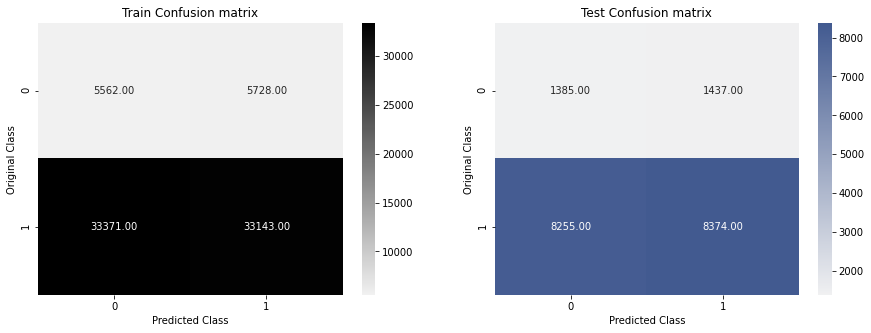

In [ ]:
#creating random model
test_data_len = X_te.shape[0]
train_data_len = X_tr.shape[0]

# we create a output array that has exactly same size as the CV data
y_train_pred = np.zeros((train_data_len,1))
for i in range(train_data_len):
    rand_c = random.randint(0, 1)
    y_train_pred[i] = (rand_c)
print("Train f1-score",f1_score(y_train,y_train_pred,average='macro'))
y_test_pred = np.zeros((test_data_len,1))
for i in range(test_data_len):
    rand_c = random.randint(0, 1)
    y_test_pred[i] = (rand_c)
print("Test f1-score",f1_score(y_test,y_test_pred,average='macro'))
confusion_matrices_plot(y_train,y_train_pred,y_test,y_test_pred,'bs_rn.png')


### Naive Bayes Model

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_tr.todense())
X_tr = scaler.transform(X_tr.todense())

In [ ]:
scaler.fit(X_te.todense())
X_te = scaler.transform(X_te.todense())

Alpha =  1e-05 Train Score 0.5781995429235557 test Score 0.5732627075348865
Alpha =  0.0001 Train Score 0.5781995429235557 test Score 0.5732627075348865
Alpha =  0.001 Train Score 0.5781995429235557 test Score 0.5732627075348865
Alpha =  0.01 Train Score 0.5781995429235557 test Score 0.5732627075348865
Alpha =  0.1 Train Score 0.5781494215720916 test Score 0.5732627075348865
Alpha =  1 Train Score 0.5781494215720916 test Score 0.5732627075348865
Alpha =  10 Train Score 0.5781712421692706 test Score 0.5732627075348865
Alpha =  100 Train Score 0.5780839550830171 test Score 0.5732627075348865
Alpha =  1000 Train Score 0.5204850622346596 test Score 0.5579127364932099


Text(0.5, 1.0, 'Alpha vs Score')

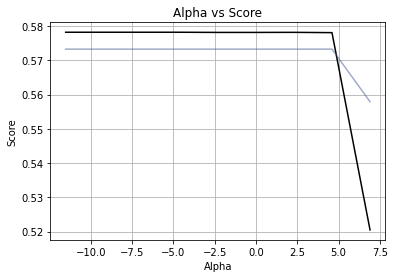

In [ ]:
# Training Logistic regression model and chekcing f1 score metric
from sklearn.naive_bayes import MultinomialNB
alpha = [10 ** x for x in range(-5, 4)]
train_scores = [] # store train scores
test_scores = [] # store test scores

for i in alpha:
    nb_cfl=MultinomialNB(alpha=i,fit_prior=False)
    nb_cfl.fit(X_tr,y_train)
    train_sc = f1_score(y_train,nb_cfl.predict(X_tr),average='macro')
    test_sc = f1_score(y_test,nb_cfl.predict(X_te),average='macro')
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Alpha = ',i,'Train Score',train_sc,'test Score',test_sc)
    
# plotting the scores vs parameters
plt.plot(np.log(alpha),train_scores,label='Train Score',color='black')
plt.plot(np.log(alpha),test_scores,label='Test Score',color='#425a90',alpha=0.5)
plt.xlabel('Alpha')
plt.ylabel('Score')
plt.grid()
plt.title('Alpha vs Score')

In [ ]:
# Parameter tuning of Logistic regression using RandomisedSearch CV technique
clf = MultinomialNB( class_prior=np.array([0.5,0.5]),fit_prior=False)

 
prams={ 'alpha': [10 ** x for x in range(-5, 4)] }

nb_cfl = RandomizedSearchCV(clf,param_distributions=prams,verbose=10,scoring='f1_macro',n_jobs=-1,random_state=25,
                               return_train_score=True)
nb_cfl.fit(X_tr,y_train)

print('mean test scores',nb_cfl.cv_results_['mean_test_score'])
print('mean train scores',nb_cfl.cv_results_['mean_train_score'])

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   15.2s finished


mean test scores [0.57810596 0.57810596 0.57810596 0.57809593 0.5781531  0.5781531
 0.5781748  0.57804373 0.46955612]
mean train scores [0.57826375 0.57826375 0.57826375 0.57826124 0.57816307 0.57816602
 0.57817148 0.57801871 0.46968199]


In [ ]:
# printing best parameters and score
print("Best Parameters: ",nb_cfl.best_params_)
print("Best Score: ",nb_cfl.best_score_)

Best Parameters:  {'alpha': 10}
Best Score:  0.5781748042968806


In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
clf = MultinomialNB(alpha = 10, class_prior=np.array([0.5,0.5]),fit_prior=False)
clf.fit(X_tr, y_train)

y_train_pred = clf.predict(X_tr)    
y_test_pred = clf.predict(X_te)


print('Train f1 score: ',f1_score(y_train,y_train_pred,average='macro'))
print('Test f1 score: ',f1_score(y_test,y_test_pred,average='macro'))

Train f1 score:  0.5781712421692706
Test f1 score:  0.5732627075348865


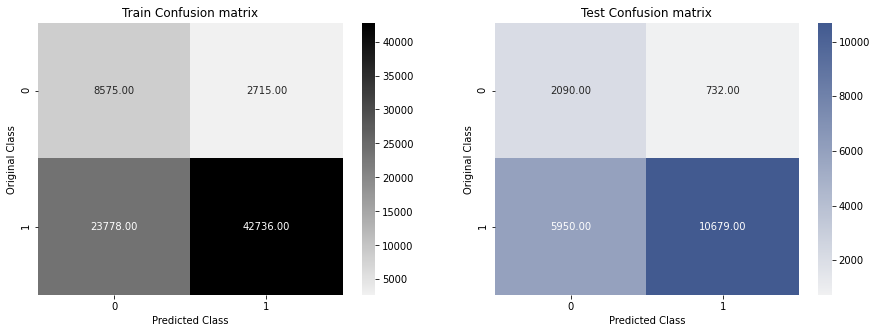

In [ ]:
confusion_matrices_plot(y_train,y_train_pred,y_test,y_test_pred,'bs_nb.png')

### Logistic Regression Model

Alpha =  1e-05 Train Score 0.8032754835521972 test Score 0.787471966907421
Alpha =  0.0001 Train Score 0.6797637956837774 test Score 0.7820214180043932
Alpha =  0.001 Train Score 0.5756912414868779 test Score 0.7314529431501915
Alpha =  0.01 Train Score 0.5176752733583474 test Score 0.5208269674817387
Alpha =  0.1 Train Score 0.4608849900913261 test Score 0.46089246119733923
Alpha =  1 Train Score 0.4608849900913261 test Score 0.46089246119733923
Alpha =  10 Train Score 0.4608849900913261 test Score 0.46089246119733923
Alpha =  100 Train Score 0.4608849900913261 test Score 0.46089246119733923
Alpha =  1000 Train Score 0.12672009338451523 test Score 0.12670048938176268


Text(0.5, 1.0, 'Alpha vs Score')

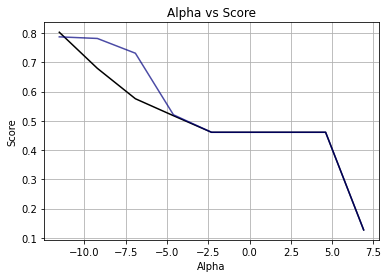

In [ ]:
# Training Logistic regression model and chekcing f1 score metric
alpha = [10 ** x for x in range(-5, 4)]
train_scores = [] # store train scores
test_scores = [] # store test scores

for i in alpha:
    lr = SGDClassifier(loss='log', penalty='l2', alpha=i, n_jobs=-1, random_state=25)
    lr.fit(X_tr,y_train)
    train_sc = f1_score(y_train,lr.predict(X_tr),average='macro')
    test_sc = f1_score(y_test,lr.predict(X_te),average='macro')
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Alpha = ',i,'Train Score',train_sc,'test Score',test_sc)
    
# plotting the scores vs parameters
plt.plot(np.log(alpha),train_scores,label='Train Score',color='black')
plt.plot(np.log(alpha),test_scores,label='Test Score',color='#000080',alpha=0.7)
plt.xlabel('Alpha')
plt.ylabel('Score')
plt.grid()
plt.title('Alpha vs Score')

In [ ]:
# Parameter tuning of Logistic regression using RandomisedSearch CV technique
sgd = SGDClassifier(loss='log', n_jobs=-1, random_state=25)
 
prams={ 'alpha': [10 ** x for x in range(-5, 4)] }

random_cfl1 = RandomizedSearchCV(sgd,param_distributions=prams,verbose=10,scoring='f1_macro',n_jobs=-1,random_state=25,
                               return_train_score=True)
random_cfl1.fit(X_tr,y_train)

print('mean test scores',random_cfl1.cv_results_['mean_test_score'])
print('mean train scores',random_cfl1.cv_results_['mean_train_score'])

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.3min finished


mean test scores [0.77745235 0.68812959 0.61063596 0.51191047 0.46088499 0.46088499
 0.46088499 0.46088499 0.46088499]
mean train scores [0.78603913 0.69077989 0.61161072 0.51202548 0.46088499 0.46088499
 0.46088499 0.46088499 0.46088499]


In [ ]:
# printing best parameters and score
print("Best Parameters: ",random_cfl1.best_params_)
print("Best Score: ",random_cfl1.best_score_)

Best Parameters:  {'alpha': 1e-05}
Best Score:  0.777452354036805


In [ ]:
# Fitting LogisticRegression mpdel on best parameters
sgd = SGDClassifier(loss='log', alpha=1e-05, n_jobs=-1, random_state=25)
sgd.fit(X_tr,y_train)

y_train_pred = sgd.predict(X_tr)
y_test_pred = sgd.predict(X_te)

# printing train and test scores 
print('Train f1 score: ',f1_score(y_train,y_train_pred,average='macro'))
print('Test f1 score: ',f1_score(y_test,y_test_pred,average='macro'))

Train f1 score:  0.8032754835521972
Test f1 score:  0.787471966907421


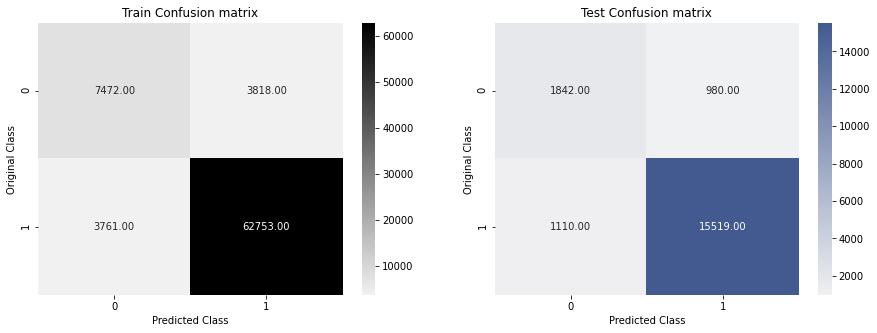

In [ ]:
confusion_matrices_plot(y_train,y_train_pred,y_test,y_test_pred,'bs_lr.png')

Observation(s):
* Total 13 numerical features and 4 categorical features are taken. 
* Logistic Regression Model is performing better than the other models.
* Logistic Regression Model is choosen as a baseline model(randomly).
* LR Model Scores: train f1-score = 0.8032754835521972 and test f1_score = 0.787471966907421
* From the both train amnd tesr confusion matrix ,we can observe that the False Psitive and False Negative values are still very large lets try to reduce these values by adding some features and through feacure selection methods.

#4.Feature Engineering

From the existing solution
1. **Sellers Count**: Total number of sellers per product (Numerical feat.).
2. **Products count**: Total number of products ordered per order (Numerical feat.).
3. **Estimated Delivery Time(in number of days)**: Estimated number of days tto deliver the producti.e (order_approval_date - order_estimated_delivery_date)(Numerical feat.).
4. **Actual Delivery Time**: Actual number of days taken to deliver the product(Numerical feat.).
5. **Difference in delivery days**:- Difference between the actual and estimated date(Numerical feat.).``` Negative : delivered early ,positive : delivered late.```

6. **Is Late**:- If delivered late then True else False (Binary).

7. **Average Product Value**:- Cheaper products might have lower quality, leaving customers unhappy (Numerical feat.).
8. **Total Order Value**:- If a customer expends more, he might expect a better order fulfilment(Numerical feat.).
9. **Order Freight Ratio**:- If a customer pays more for freight, he might expect a better service(Numerical feat.).
10. **Purchase Day of Week**:- Day of week on which purchase was made(Numerical feat.).
11. **is_reviewed**:- If the review comment is given or not.

other:

12. **Recency** : number of days since the last purchase(present date -last ordered date)(Numerical feat.).
13. **Frequency** : number of transactions made over the period(present date -last ordered date)(Numerical feat.).
14. **Monetary** : amount spent over a given period time (Numerical feat.)
15. **RFM Levels** :Behavioral segmentations using above three features (Categorical).
16. **words per review** : Total number of words per review (Numerical feat.).

In [ ]:
data_n = pd.read_pickle('final.pkl')
data_n.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,review_score,review_comment_message,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_month_yr,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day,day_to_delivery,words_per_review
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,1,credit_card,1,18.12,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,1,"Não testei o produto ainda, mas ele veio corre...",2017,10,Oct,201710,20171002,Oct-17,2,0,Mon,10,Morning,8,32
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-18 14:44:43,2017-08-28,1,credit_card,3,37.77,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,1,Deveriam embalar melhor o produto. A caixa vei...,2017,8,Aug,201708,20170815,Aug-17,15,1,Tue,18,Afternoon,2,16
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-07 18:30:01,2017-08-15,1,credit_card,1,37.77,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,1,"Só achei ela pequena pra seis xícaras ,mais é ...",2017,8,Aug,201708,20170802,Aug-17,2,2,Wed,18,Afternoon,5,12
5,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2017-10-23 23:26:46,2017-10-25 02:14:11,2017-11-07 18:04:59,2017-11-13,1,boleto,1,44.09,e781fdcc107d13d865fc7698711cc572,88032,florianopolis,SC,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-31 02:14:11,29.99,14.10,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,1,nao_reveja,2017,10,Oct,201710,20171023,Oct-17,23,0,Mon,23,Night,14,1
6,6ea2f835b4556291ffdc53fa0b3b95e8,c7340080e394356141681bd4c9b8fe31,delivered,2017-11-24 21:27:48,2017-11-25 00:21:09,2017-12-28 18:59:23,2017-12-21,1,credit_card,10,356.12,3e4fd73f1e86b135b9b121d6abbe9597,19400,presidente venceslau,SP,1,be021417a6acb56b9b50d3fd2714baa8,f5f46307a4d15880ca14fab4ad9dfc9b,2017-11-30 00:21:09,339.00,17.12,utilidades_domesticas,48.0,664.0,6.0,14300.0,38.0,34.0,34.0,housewares,0,"Inicialmente, na data da compra o produto era ...",2017,11,Nov,201711,20171124,Nov-17,24,4,Fri,21,Night,33,22


In [ ]:
#sellers count for each product
fea_1= data_n.groupby('product_id').count()['seller_id']
fea_1_df = pd.DataFrame()
fea_1_df['product_id']= fea_1.index
fea_1_df['sellers_count']= fea_1.values
fea_1_df.head()

,product_id,sellers_count
0,00066f42aeeb9f3007548bb9d3f33c38,1
1,00088930e925c41fd95ebfe695fd2655,1
2,0009406fd7479715e4bef61dd91f2462,1
3,000b8f95fcb9e0096488278317764d19,2
4,000d9be29b5207b54e86aa1b1ac54872,1


In [ ]:
#sellers count for each product
fea_2 = data_n.groupby('order_id').count()['product_id']
fea_2_df = pd.DataFrame()
fea_2_df['order_id']= fea_2.index
fea_2_df['products_count']= fea_2.values
fea_2_df.head()


,order_id,products_count
0,00010242fe8c5a6d1ba2dd792cb16214,1
1,00018f77f2f0320c557190d7a144bdd3,1
2,000229ec398224ef6ca0657da4fc703e,1
3,00024acbcdf0a6daa1e931b038114c75,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,1


In [ ]:
# Adding the seller count and products count feature to the final data set
data_n = pd.merge(data_n,fea_1_df,on='product_id')
data_n = pd.merge(data_n,fea_2_df,on='order_id')


In [ ]:
#Extrcting Features (taken from existing soluting )

# https://www.kaggle.com/andresionek/predicting-customer-satisfaction

# calculating estimated delivery time
data_n['est_delivery_t'] = (data_n['order_estimated_delivery_date'] - data_n['order_approved_at']).dt.days

# calculating actual delivery time
data_n['act_delivery_t'] = (data_n['order_delivered_customer_date'] - data_n['order_approved_at']).dt.days

# calculating diff_in_delivery_time
data_n['diff_in_delivery_t'] = data_n['est_delivery_t'] - data_n['act_delivery_t']

# finding if delivery was lare
data_n['on_time_delivery'] = data_n['order_delivered_customer_date'] < data_n['order_estimated_delivery_date']
data_n['on_time_delivery'] = data_n['on_time_delivery'].astype('int')

# calculating mean product value
data_n['avg_prdt_value'] = data_n['price']/data_n['products_count']

# finding total order cost
data_n['total_order_cost'] = data_n['price'] + data_n['freight_value']

# calculating order freight ratio
data_n['order_freight_ratio'] = data_n['freight_value']/data_n['price']

# finding the day of week on which order was made
data_n['purchase_dayofweek'] = pd.to_datetime(data_n['order_purchase_timestamp']).dt.dayofweek

# adding is_reviewed where 1 is if review comment is given otherwise 0.
data_n['is_reviewed'] = (data_n['review_comment_message'] != 'no_review').astype('int')

In [ ]:
#list(data.groupby('customer_id')['order_purchase_dayofweek'].agg([('year_avg','mean')])['year_avg'])

In [ ]:
rfm = pd.read_pickle('rfm.pkl')
rfm.head()

,recency,frequency,monetary,f_quartile,r_quartile,m_quartile,RFM_Score,RFM_Score_s,RFM_Level
customer_unique_id,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,115,1,141.90,1,4,3,413,8,Champions
0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,27.19,1,4,1,411,6,Potential
0000f46a3911fa3c0805444483337064,541,1,86.22,1,1,2,112,4,Needs Attention
0000f6ccb0745a6a4b88665a16c9f078,325,1,43.62,1,2,1,211,4,Needs Attention
0004aac84e0df4da2b147fca70cf8255,292,1,196.89,1,2,4,214,7,Loyal


In [ ]:
data_n = data_n.merge(rfm ,on ='customer_unique_id',how='left')

In [ ]:
data_n.isnull().sum()

order_id                    0
customer_id                 0
order_status                0
order_purchase_timestamp    0
order_approved_at           0
                           ..
r_quartile                  0
m_quartile                  0
RFM_Score                   0
RFM_Score_s                 0
RFM_Level                   0
Length: 65, dtype: int64

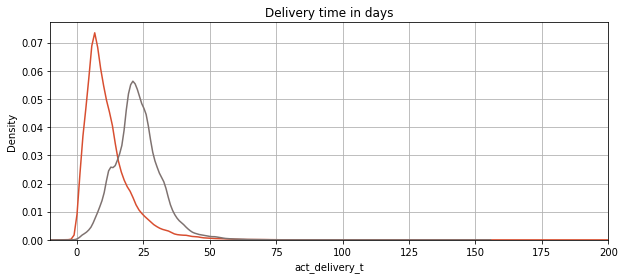

In [ ]:
# Delivery estimated time and actual delivery time
plt.figure(figsize=(10,4))
plt.title("Delivery time in days")
plt.xlim(-10, 200)
plt.grid()

ax1 = sns.kdeplot(data_n['act_delivery_t'], color="#D84E30", label='Delivery time')
ax2 = sns.kdeplot(data_n['est_delivery_t'], color="#7E7270", label='Estimated delivery time')
plt.savefig('pr_fig1.png', dpi=480, bbox_inches='tight')

In [ ]:
col= ['order_id',
 'customer_id',
 'order_purchase_timestamp',
 'order_approved_at',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
  'customer_unique_id',
 'order_item_id',
 'product_id',
 'seller_id',
 'shipping_limit_date',
  'order_purchase_year',
 'order_purchase_month',
 'order_purchase_month_name',
 'order_purchase_year_month',
 'order_purchase_date',
 'order_purchase_month_yr',
 'order_purchase_day',
 'order_purchase_dayofweek',
 'order_purchase_dayofweek_name',
 'order_purchase_hour',
 'order_purchase_time_day',
  'f_quartile',
 'r_quartile',
 'm_quartile',
 'RFM_Score','RFM_Score_s','product_category_name']


In [ ]:
data_n.drop(columns=col,axis=1,inplace=True)
data_n.head()

,order_status,payment_sequential,payment_type,payment_installments,payment_value,customer_zip_code_prefix,customer_city,customer_state,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,review_score,review_comment_message,day_to_delivery,words_per_review,sellers_count,products_count,est_delivery_t,act_delivery_t,diff_in_delivery_t,on_time_delivery,avg_prdt_value,total_order_cost,order_freight_ratio,purchase_dayofweek,is_reviewed,recency,frequency,monetary,RFM_Level
0,delivered,1,credit_card,1,18.12,3149,sao paulo,SP,29.99,8.72,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,1,"Não testei o produto ainda, mas ele veio corre...",8,32,4,1,15,8,7,1,29.99,38.71,0.290764,0,1,335,2,62.23,Promising
1,delivered,1,credit_card,3,37.77,3366,sao paulo,SP,29.99,7.78,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,1,Deveriam embalar melhor o produto. A caixa vei...,2,16,4,1,12,2,10,1,29.99,37.77,0.259420,1,1,383,1,37.77,Require Activation
2,delivered,1,credit_card,1,37.77,2290,sao paulo,SP,29.99,7.78,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,1,"Só achei ela pequena pra seis xícaras ,mais é ...",5,12,4,1,12,4,8,1,29.99,37.77,0.259420,2,1,396,1,37.77,Require Activation
3,delivered,1,boleto,1,44.09,88032,florianopolis,SC,29.99,14.10,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,1,nao_reveja,14,1,4,1,18,13,5,1,29.99,44.09,0.470157,0,1,314,1,44.09,Needs Attention
4,delivered,1,credit_card,10,356.12,19400,presidente venceslau,SP,339.00,17.12,48.0,664.0,6.0,14300.0,38.0,34.0,34.0,housewares,0,"Inicialmente, na data da compra o produto era ...",33,22,1,1,25,33,-8,0,339.00,356.12,0.050501,4,1,282,1,356.12,Loyal


In [ ]:
#text preprocessing
processed_text = preprocess_text(data_n['review_comment_message'].values)

100%|██████████| 97255/97255 [00:25<00:00, 3793.41it/s]


In [ ]:
data_n['review_comment_message'] = processed_text
data_n['review_comment_message'].head(5)

0    neg test produt aind vei corret boa cond apen ...
1    dev embal melhor produt caix vei tod amass vou...
2                   ach pequen pra seil xíc bom produt
3                                           neg _revej
4    inic dat compr produt ser entreg numer numer h...
Name: review_comment_message, dtype: object

Spliting data in Train and Test.

In [ ]:
y = data_n['review_score'].values
X = data_n.drop(['review_score'], axis=1)
print("      X ","        y")
print(X.shape,y.shape)
print('\n')
X.head(1)   

      X          y
(97255, 36) (97255,)




,order_status,payment_sequential,payment_type,payment_installments,payment_value,customer_zip_code_prefix,customer_city,customer_state,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,review_comment_message,day_to_delivery,words_per_review,sellers_count,products_count,est_delivery_t,act_delivery_t,diff_in_delivery_t,on_time_delivery,avg_prdt_value,total_order_cost,order_freight_ratio,purchase_dayofweek,is_reviewed,recency,frequency,monetary,RFM_Level
0,delivered,1,credit_card,1,18.12,3149,sao paulo,SP,29.99,8.72,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,"Não testei o produto ainda, mas ele veio corre...",8,32,4,1,15,8,7,1,29.99,38.71,0.290764,0,1,335,2,62.23,Promising


In [ ]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=25)


print(" X_train","   y_train")
print(X_train.shape,y_train.shape)
print('-'*15)
print("X_test","    y_test")
print(X_test.shape,y_test.shape)

 X_train    y_train
(77804, 36) (77804,)
---------------
X_test     y_test
(19451, 36) (19451,)


In [ ]:
pickle.dump(X_train,open('X_train.pkl','wb'))
pickle.dump(X_test,open('X_test.pkl','wb'))
pickle.dump(y_train,open('y_train.pkl','wb'))
pickle.dump(y_test,open('y_test.pkl','wb'))

In [ ]:
X_train = pickle.load(open('X_train.pkl', 'rb'))
X_test = pickle.load(open('X_test.pkl', 'rb'))
y_train = pickle.load(open('y_train.pkl','rb'))
y_test = pickle.load(open('y_test.pkl','rb'))

#4.1 Featurization

### Featurization of text data

In [ ]:
# encoding review comment message using Tfidf weighted W2V
tfidf = TfidfVectorizer()
tfidf.fit(X_train['review_comment_message'])


# we are converting a dictionary with word as a key, and the idf as a value
tf_values = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))
tfidf_words = set(tfidf.get_feature_names())
glove_words = list(ft_model.wv.vocab.keys()) # list(embeddings.keys())

tfidf_w2v_vectors_train = tfidfWord2Vector(X_train['review_comment_message'].values,glove_words,tfidf_words,tf_values)
tfidf_w2v_vectors_test = tfidfWord2Vector(X_test['review_comment_message'].values,glove_words,tfidf_words,tf_values)

100%|██████████| 19451/19451 [25:46<00:00, 12.58it/s]


In [ ]:
tfidf_w2v_vectors_train.shape,tfidf_w2v_vectors_test.shape

((77804, 300), (19451, 300))

In [ ]:
pickle.dump(tfidf_w2v_vectors_train,open('tfidf_w2v_vectors_train.pkl','wb'))
pickle.dump(tfidf_w2v_vectors_test,open('tfidf_w2v_vectors_test.pkl','wb'))

## Encoding Categorical Features

### Encoding Categorical Features: order_status

In [ ]:

vectorizer = CountVectorizer(binary= True)
vectorizer.fit(X_train['order_status'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
order_st_tr = vectorizer.transform(X_train['order_status'].values)

order_st_te = vectorizer.transform(X_test['order_status'].values)

print("After vectorizations")
print(order_st_tr.shape, y_train.shape)
print(order_st_tr.shape, y_test.shape)


After vectorizations
(77804, 7) (77804,)
(77804, 7) (19451,)


### Encoding Categorical Features:payment_type

In [ ]:
vectorizer = CountVectorizer(binary= True)
vectorizer.fit(X_train['payment_type'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
pay_typ_tr = vectorizer.transform(X_train['payment_type'].values)

pay_typ_te = vectorizer.transform(X_test['payment_type'].values)

print("After vectorizations")
print(pay_typ_tr.shape, y_train.shape)
print(pay_typ_tr.shape, y_test.shape)


After vectorizations
(77804, 4) (77804,)
(77804, 4) (19451,)


### Encoding Categorical Features:product_category_name_english

In [ ]:
vectorizer = CountVectorizer(binary= True)
vectorizer.fit(X_train['product_category_name_english'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
prod_cat_tr = vectorizer.transform(X_train['product_category_name_english'].values)

prod_cat_te = vectorizer.transform(X_test['product_category_name_english'].values)

print("After vectorizations")
print(prod_cat_tr.shape, y_train.shape)
print(prod_cat_tr.shape, y_test.shape)


After vectorizations
(77804, 71) (77804,)
(77804, 71) (19451,)


### Encoding Categorical Features: customer_state

In [ ]:
vectorizer = CountVectorizer(binary= True)
vectorizer.fit(X_train['customer_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
state_tr = vectorizer.transform(X_train['customer_state'].values)

state_te = vectorizer.transform(X_test['customer_state'].values)

print("After vectorizations")
print(state_tr.shape, y_train.shape)
print(state_tr.shape, y_test.shape)


After vectorizations
(77804, 27) (77804,)
(77804, 27) (19451,)


### Encoding Categorical Features: RFM_Level

In [ ]:
vectorizer = CountVectorizer(binary= True)
vectorizer.fit(X_train['RFM_Level'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
rfm_tr = vectorizer.transform(X_train['RFM_Level'].values)

rfm_te = vectorizer.transform(X_test['RFM_Level'].values)

print("After vectorizations")
print(rfm_tr.shape, y_train.shape)
print(rfm_tr.shape, y_test.shape)


After vectorizations
(77804, 11) (77804,)
(77804, 11) (19451,)


## Numerical features

In [ ]:
# numerical features
num=['payment_sequential',
 'payment_installments',
 'payment_value',
 'customer_zip_code_prefix',
 'price',
 'freight_value',
 'product_name_lenght',
 'product_description_lenght',
 'product_photos_qty',
 'product_weight_g',
 'product_length_cm',
 'product_height_cm',
 'product_width_cm',
 'day_to_delivery',
 'recency',
 'frequency',
 'monetary',
 'sellers_count',
 'products_count',
 'est_delivery_t',
 'act_delivery_t',
 'diff_in_delivery_t',
 'on_time_delivery',
 'avg_prdt_value',
 'total_order_cost',
 'order_freight_ratio',
 'purchase_dayofweek',
 'is_reviewed','words_per_review']

In [ ]:
tr=[]
te=[]
for i in num:
  a,b = normalizer(i)
  tr.append(a)
  te.append(b)



In [ ]:
from scipy.sparse import hstack,csr_matrix
import numpy as np

X_tr_num = np.hstack((tr))
X_te_num = np.hstack((te))


print("Final Data matrix")
print(X_tr_num.shape, y_train.shape)
print(X_te_num.shape, y_test.shape)

Final Data matrix
(77804, 29) (77804,)
(19451, 29) (19451,)


In [ ]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((tfidf_w2v_vectors_train,order_st_tr,pay_typ_tr,prod_cat_tr,state_tr,rfm_tr,X_tr_num)).tocsr()
X_te = hstack((tfidf_w2v_vectors_test,order_st_te,pay_typ_te,prod_cat_te,state_te,rfm_te,X_te_num)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)

print(X_te.shape, y_test.shape)
print("="*100)
print('')

Final Data matrix
(77804, 449) (77804,)
(19451, 449) (19451,)



In [ ]:
pickle.dump(X_tr,open('X_tr.pkl','wb'))
pickle.dump(X_te,open('X_te.pkl','wb'))


In [ ]:
X_tr = pickle.load(open('X_tr.pkl', 'rb'))
X_te = pickle.load(open('X_te.pkl', 'rb'))


#4.2 Baseline Model:(Logistic Regression Model)

Alpha =  1e-05 Train Score 0.7471470259347864 test Score 0.7328464710133609
Alpha =  0.0001 Train Score 0.7718947384878527 test Score 0.7629530382245009
Alpha =  0.001 Train Score 0.6981267604598248 test Score 0.6859294998739176
Alpha =  0.01 Train Score 0.6767653233105615 test Score 0.6696703441050166
Alpha =  0.1 Train Score 0.4608849900913261 test Score 0.46089246119733923
Alpha =  1 Train Score 0.4608849900913261 test Score 0.46089246119733923
Alpha =  10 Train Score 0.4608849900913261 test Score 0.46089246119733923
Alpha =  100 Train Score 0.4608849900913261 test Score 0.46089246119733923
Alpha =  1000 Train Score 0.4608849900913261 test Score 0.46089246119733923


Text(0.5, 1.0, 'Alpha vs Score')

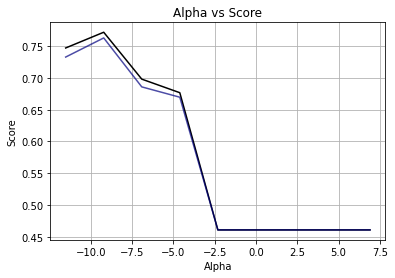

In [ ]:
# Training Logistic regression model and chekcing f1 score metric
alpha = [10 ** x for x in range(-5, 4)]
train_scores = [] # store train scores
test_scores = [] # store test scores

for i in alpha:
    lr = SGDClassifier(loss='log', penalty='l2', alpha=i, n_jobs=-1, random_state=25)
    lr.fit(X_tr,y_train)
    train_sc = f1_score(y_train,lr.predict(X_tr),average='macro')
    test_sc = f1_score(y_test,lr.predict(X_te),average='macro')
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Alpha = ',i,'Train Score',train_sc,'test Score',test_sc)
    
# plotting the scores vs parameters
plt.plot(np.log(alpha),train_scores,label='Train Score',color='black')
plt.plot(np.log(alpha),test_scores,label='Test Score',color='#000080',alpha=0.7)
plt.xlabel('Alpha')
plt.ylabel('Score')
plt.grid()
plt.title('Alpha vs Score')

In [ ]:
# Parameter tuning of Logistic regression using RandomisedSearch CV technique
sgd = SGDClassifier(loss='log', n_jobs=-1, random_state=25)
 
prams={ 'alpha': [10 ** x for x in range(-5, 4)] }

random_cfl1 = RandomizedSearchCV(sgd,param_distributions=prams,verbose=10,scoring='f1_macro',n_jobs=-1,random_state=25,
                               return_train_score=True)
random_cfl1.fit(X_tr,y_train)

print('mean test scores',random_cfl1.cv_results_['mean_test_score'])
print('mean train scores',random_cfl1.cv_results_['mean_train_score'])

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   56.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.0min finished


mean test scores [0.78577803 0.74122438 0.69037477 0.67691284 0.46088499 0.46088499
 0.46088499 0.46088499 0.46088499]
mean train scores [0.79138251 0.74361285 0.69093999 0.67678027 0.46088499 0.46088499
 0.46088499 0.46088499 0.46088499]


In [ ]:
# printing best parameters and score
print("Best Parameters: ",random_cfl1.best_params_)
print("Best Score: ",random_cfl1.best_score_)

Best Parameters:  {'alpha': 1e-05}
Best Score:  0.7857780327343431


In [ ]:
# Fitting LogisticRegression mpdel on best parameters
sgd = SGDClassifier(loss='log', alpha=1e-05, n_jobs=-1, random_state=25)
sgd.fit(X_tr,y_train)


y_train_pred = sgd.predict(X_tr)
y_test_pred = sgd.predict(X_te)

# printing train and test scores 
print('Train f1 score: ',f1_score(y_train,y_train_pred,average='macro'))
print('Test f1 score: ',f1_score(y_test,y_test_pred,average='macro'))

Train f1 score:  0.7471470259347864
Test f1 score:  0.7328464710133609


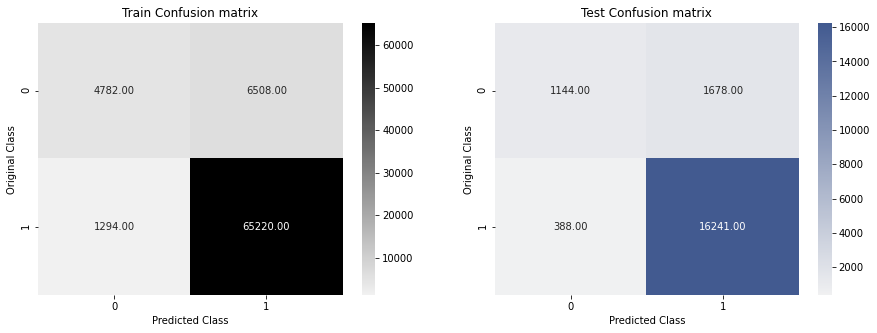

In [ ]:
confusion_matrices_plot(y_train,y_train_pred,y_test,y_test_pred,'feat_md_lr.png')

Observation(s):

* After adding new features ,we have total 29 numerical features and 5 categorical features and text data(300 dim).

* Train f1 score:  0.74714702593478647,Test f1 score:  0.7328464710133609
* From the both train and test confusion matrix , we can observe that the false positive values are increased.we will try to reduce it by selection important features.


#5.Feature Extraction/Selection using AutoEncoders

In [ ]:

#Importing the Libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import load_model



In [ ]:
#Code Source-https://machinelearningmastery.com/autoencoder-for-classification/

# AutoEncoder Model Preparation
n_inputs = X_tr.shape[1]
# define encoder
input_data_shape= Input(shape=(n_inputs,))
# encoder level 1
encoder= Dense(round(float(n_inputs) / 2.0))(input_data_shape)
encoder = BatchNormalization()(encoder)
encoder= LeakyReLU()(encoder)
# encoder level 2
encoder= Dense(round(float(n_inputs) / 3.0))(encoder)
encoder= BatchNormalization()(encoder)
encoder= LeakyReLU()(encoder)
# bottleneck (half of Input)
n_bottleneck = round(float(n_inputs) / 4.0)
bottleneck = Dense(n_bottleneck)(encoder)
# define decoder, level 1
decoder = Dense(round(float(n_inputs) / 3.0))(bottleneck)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)
# decoder level 2
decoder = Dense(round(float(n_inputs) / 2.0))(decoder)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)

In [ ]:
# output layer
output = Dense(n_inputs, activation='linear')(decoder)
# define autoencoder model
model = Model(inputs=input_data_shape, outputs=output)
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')



In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 449)]             0         
_________________________________________________________________
dense (Dense)                (None, 224)               100800    
_________________________________________________________________
batch_normalization (BatchNo (None, 224)               896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 224)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 150)               33750     
_________________________________________________________________
batch_normalization_1 (Batch (None, 150)               600       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 150)               0     

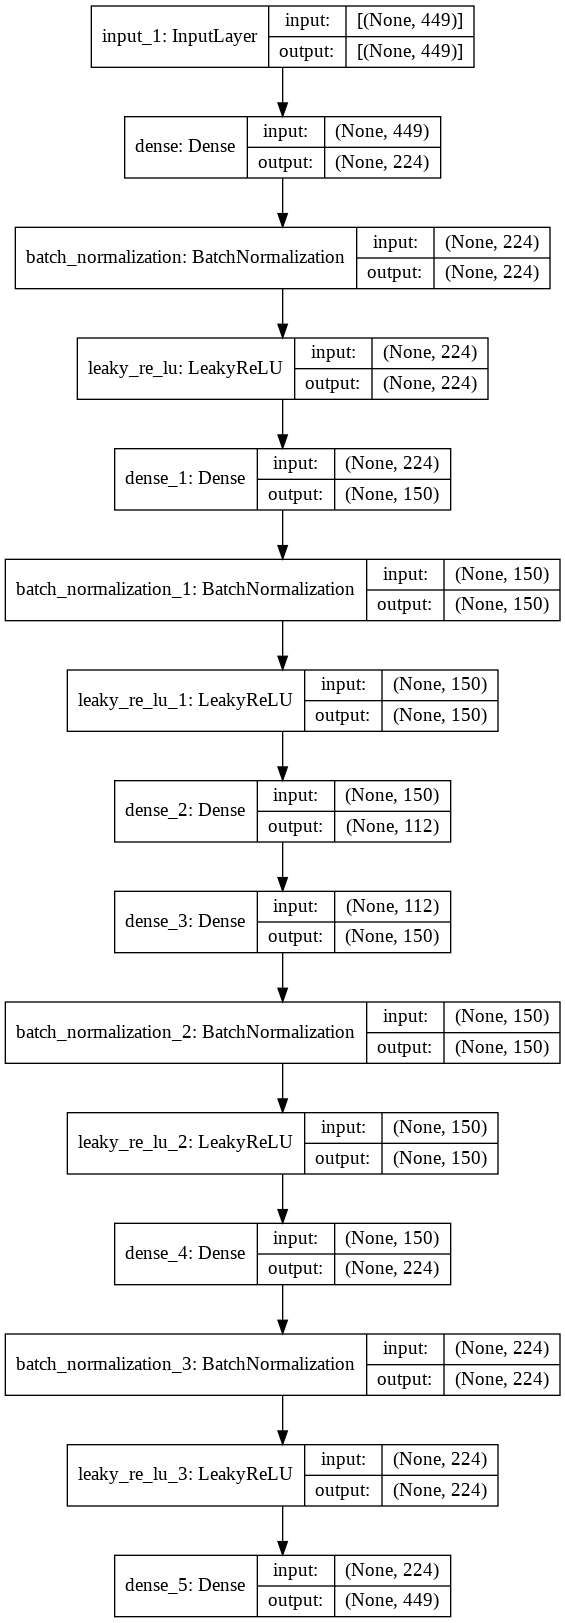

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='encode.png', show_shapes=True, show_layer_names=True)

In [ ]:
# fit the autoencoder model to reconstruct input
history = model.fit(X_tr, y_train, epochs=50, batch_size=16, verbose=2, validation_data=(X_te,y_test))

Epoch 1/50
4863/4863 - 29s - loss: 0.0901 - val_loss: 0.0741
Epoch 2/50
4863/4863 - 25s - loss: 0.0774 - val_loss: 0.0725
Epoch 3/50
4863/4863 - 25s - loss: 0.0737 - val_loss: 0.0712
Epoch 4/50
4863/4863 - 25s - loss: 0.0719 - val_loss: 0.0700
Epoch 5/50
4863/4863 - 25s - loss: 0.0697 - val_loss: 0.0720
Epoch 6/50
4863/4863 - 25s - loss: 0.0685 - val_loss: 0.0686
Epoch 7/50
4863/4863 - 25s - loss: 0.0677 - val_loss: 0.0675
Epoch 8/50
4863/4863 - 25s - loss: 0.0670 - val_loss: 0.0701
Epoch 9/50
4863/4863 - 25s - loss: 0.0657 - val_loss: 0.0682
Epoch 10/50
4863/4863 - 25s - loss: 0.0658 - val_loss: 0.0676
Epoch 11/50
4863/4863 - 25s - loss: 0.0653 - val_loss: 0.0678
Epoch 12/50
4863/4863 - 25s - loss: 0.0646 - val_loss: 0.0691
Epoch 13/50
4863/4863 - 25s - loss: 0.0643 - val_loss: 0.0668
Epoch 14/50
4863/4863 - 25s - loss: 0.0640 - val_loss: 0.0698
Epoch 15/50
4863/4863 - 25s - loss: 0.0634 - val_loss: 0.0679
Epoch 16/50
4863/4863 - 25s - loss: 0.0629 - val_loss: 0.0664
Epoch 17/50
4863/

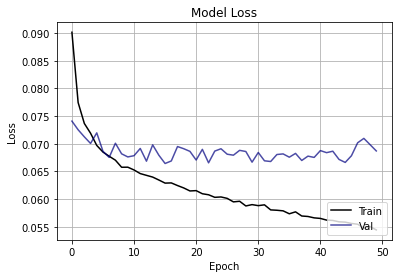

In [ ]:

plt.plot(history.history['loss'],color='black')
plt.plot(history.history['val_loss'],color='#000080',alpha=0.7)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.grid()
plt.savefig('enc_loss.png', dpi=480, bbox_inches='tight')
plt.show()

In [ ]:
# define an encoder model (without the decoder)
encoder = Model(inputs=input_data_shape, outputs=bottleneck)
# save the encoder to file
encoder.save('encoder.h5')



In [ ]:
# load the model from file
encoder = load_model('encoder.h5')

# encode the train data
X_train_encode = encoder.predict(X_tr)
print('X_train_encode',X_train_encode.shape)
# encode the test data
X_test_encode = encoder.predict(X_te)
print('X_test_encode',X_test_encode.shape)

X_train_encode (77804, 112)
X_test_encode (19451, 112)


Alpha =  1e-05 Train Score 0.8323470453224583 test Score 0.7830199431668516
Alpha =  0.0001 Train Score 0.809757583457868 test Score 0.7681544749974051
Alpha =  0.001 Train Score 0.7803926933363365 test Score 0.7482640363810835
Alpha =  0.01 Train Score 0.8256881038423738 test Score 0.7817929515995984
Alpha =  0.1 Train Score 0.8561932056894956 test Score 0.8026991971236722
Alpha =  1 Train Score 0.8431716374461672 test Score 0.7914563177370799
Alpha =  10 Train Score 0.7972149649023633 test Score 0.7582044549893883
Alpha =  100 Train Score 0.4975153738113035 test Score 0.5015444651090336
Alpha =  1000 Train Score 0.41492550409377355 test Score 0.41855725540672034


Text(0.5, 1.0, 'Alpha vs Score')

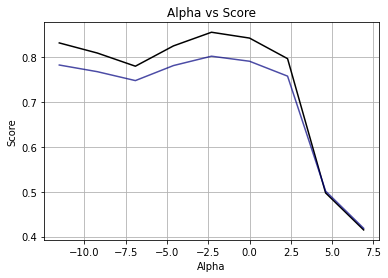

In [ ]:
# Training Logistic regression model and chekcing f1 score metric
alpha = [10 ** x for x in range(-5, 4)]
train_scores = [] # store train scores
test_scores = [] # store test scores

for i in alpha:
    lr = SGDClassifier(loss='log', penalty='l2', alpha=i, n_jobs=-1, random_state=25)
    lr.fit(X_train_encode,y_train)
    train_sc = f1_score(y_train,lr.predict(X_train_encode),average='macro')
    test_sc = f1_score(y_test,lr.predict(X_test_encode),average='macro')
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Alpha = ',i,'Train Score',train_sc,'test Score',test_sc)
    
# plotting the scores vs parameters
plt.plot(np.log(alpha),train_scores,label='Train Score',color='black')
plt.plot(np.log(alpha),test_scores,label='Test Score',color='#000080',alpha=0.7)
plt.xlabel('Alpha')
plt.ylabel('Score')
plt.grid()
plt.title('Alpha vs Score')

In [ ]:
# Parameter tuning of Logistic regression using RandomisedSearch CV technique
sgd = SGDClassifier(loss='log', n_jobs=-1, random_state=25)
 
prams={ 'alpha': [10 ** x for x in range(-5, 4)] }

random_cfl1 = RandomizedSearchCV(sgd,param_distributions=prams,verbose=10,scoring='f1_macro',n_jobs=-1,random_state=25,
                               return_train_score=True)
random_cfl1.fit(X_train_encode,y_train)

print('mean test scores',random_cfl1.cv_results_['mean_test_score'])
print('mean train scores',random_cfl1.cv_results_['mean_train_score'])

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   47.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  2.2min finished


mean test scores [0.80747246 0.81447023 0.81768197 0.82956808 0.84844702 0.84373955
 0.80663288 0.50420148 0.44323372]
mean train scores [0.8066909  0.81410218 0.81616728 0.83046698 0.84858975 0.84324043
 0.80612625 0.50427918 0.44329521]


In [ ]:
# printing best parameters and score
print("Best Parameters: ",random_cfl1.best_params_)
print("Best Score: ",random_cfl1.best_score_)

Best Parameters:  {'alpha': 0.1}
Best Score:  0.8484470211660341


In [ ]:
# Fitting LogisticRegression mpdel on best parameters
sgd = SGDClassifier(loss='log', alpha=0.1, n_jobs=-1, random_state=25)
sgd.fit(X_train_encode,y_train)

y_train_pred = sgd.predict(X_train_encode)
y_test_pred = sgd.predict(X_test_encode)

# printing train and test scores 
print('Train f1 score: ',f1_score(y_train,y_train_pred,average='macro'))
print('Test f1 score: ',f1_score(y_test,y_test_pred,average='macro'))

Train f1 score:  0.8561932056894956
Test f1 score:  0.8026991971236722


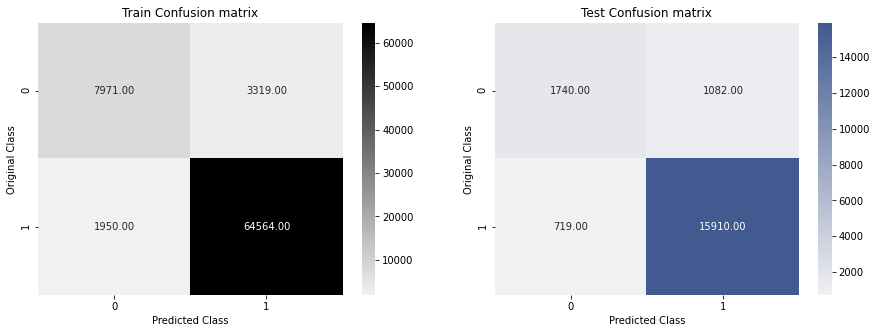

In [ ]:
confusion_matrices_plot(y_train,y_train_pred,y_test,y_test_pred,'encoder.png')

Observation(s):

* After extracting important featres using auto_encoder ,we have 112 features.
* The train f1_score is increased to 0.8561932056894956 and and test f1-score to 0.8026991971236722.

* lets try other machine learning models to improve the score